## Lecture 4: Gradient descent continued, and stochastic gradient descent

## CS4787 — Principles of Large-Scale Machine Learning Systems

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\norm}[1]{\left\|#1\right\|}$

In [1]:
import numpy
import scipy
import matplotlib
from matplotlib import pyplot
import time

### Recall: from last time, we showed that...

If we assume that for all $x, y \in \R^d$, $\| \nabla f(x) - \nabla f(y) \| \le L \cdot \| x - y \|$, then

$$f(w_{t+1}) \le
f(w_t) 
- \alpha \left(1 - \frac{1}{2} \alpha L \right) \cdot \| \nabla f(w_t) \|^2.$$

If we choose our step size $\alpha$ to be _small enough_ that $1 \ge \alpha L$, then this simplifies to

$$f(w_{t+1}) \le
f(w_t) 
- \frac{\alpha}{2} \cdot \| \nabla f(w_t) \|^2.$$

That is, **the objective is guaranteed to decrease at each iteration**! This matches our intuition for why gradient descent should work.

### An aside...why do we need sufficiently small step size?

With too large a step size, we can overshoot the optimum!

Consider the following case of $f(w) = \frac{1}{2} w^2$. Here $f'(w) = \nabla f(w) = w$ (and $f''(w) = 1$), so it's $L$-smooth with $L = 1$. Suppose we're at $w_t = 2$ as shown here:

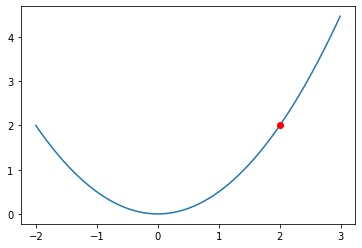

In [2]:
x = numpy.arange(-2,3,0.01)
y = x**2 / 2
pyplot.plot(x,y);
pyplot.scatter([2.0],[2.0**2/2], c="r", zorder=10)

Here our GD update will be $w_{t+1} = w_t - \alpha f(w_t) = 2 - \alpha \cdot 2$. If we step with $\alpha = 1$, we go directly to the optimum at $w = 0$. But! If we step with a larger $\alpha$, we overshoot, and for $\alpha > 2$ our loss $f(w)$ actually increases. This illustrates why having _sufficiently small steps_ is necessary for our proof.

### Why is our L-smoothness assumption necessary?

We can also use a simple example to illustrate why assuming some sort of smoothness is necessary to show this result. Consider the (dumb) example of $f(w) = \sqrt{|w|}$.

In [3]:
x = numpy.arange(-3,3,0.01)
y = numpy.sqrt(numpy.abs(x))
w = 2;
prev_w = numpy.array(w)
alpha = 0.5;

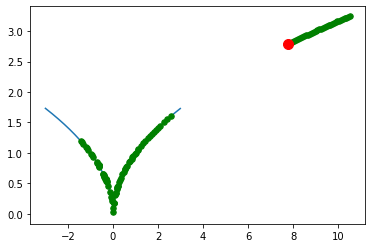

In [22]:
for it in range(100):
    w = w - alpha * numpy.sign(w)/(2*numpy.sqrt(numpy.abs(w)))
    prev_w = numpy.append(prev_w,w)
pyplot.plot(x,y);
pyplot.scatter(prev_w, numpy.sqrt(numpy.abs(prev_w)), [30], c="g", zorder=100)
pyplot.scatter([w], [numpy.sqrt(numpy.abs(w))], [100], c="r", zorder=100)
prev_w = numpy.append(prev_w,w)

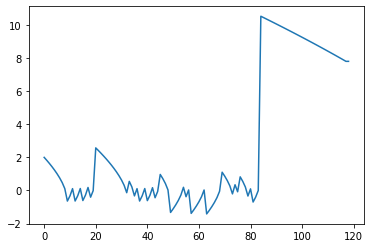

In [23]:
pyplot.plot(prev_w)

## Returning to our proof from Monday...

Said that $f(w_T) \ge f^*$, so $-f(w_T) \le -f^*$

$$f(w_0) - f(w_T) \le f(w_0) - f^*$$

Now, if we sum this up across $T$ iterations of gradient descent, we get

$$
  \frac{1}{2} \alpha \sum_{t = 0}^{T-1} \norm{ \nabla f(w_t) }^2
  \le
  \sum_{t = 0}^{T-1} \left(
    f(w_t)
    -
    f(w_{t+1})
  \right)
  =
  f(w_0) - f(w_T)
  \le
  f(w_0) - f^*
$$

where $f^*$ is the global minimum value of the loss function $f$.
From here, we can get

$$
  \min_{t \in \{0, \ldots, T-1\}} \norm{ \nabla f(w_t) }^2
  \le
  \frac{1}{T} \sum_{t = 0}^{T-1} \norm{ \nabla f(w_t) }^2
  \le
  \frac{2 (f(w_0) - f^*)}{\alpha T}.
$$


This means that the smallest gradient we observe after $T$ iterations is getting smaller proportional to $1/T$.
So gradient descent converges...
* as long as we look at the smallest observed gradient
* and we care about finding a point where the gradient is small

<div style="text-align:center;color:ForestGreen;font-size:larger;font-weight:bold;">Question: does this ensure that gradient descent converges to the global optimum (i.e. the value of $w$ that minimizes $f$ over all $w \in \R^d$)?</div>

...

### When can we ensure that gradient descent _does_ converge to the unique global optimum?

Certainly, we can do this when there is only one global optimum.

The simplest case of this is the case of **convex objectives**.

## Convex Functions

A function $f: \R^d \rightarrow \R$ is convex if for all $x, y \in \R^d$, and all $\eta \in [0,1]$

$$f(\eta x + (1 - \eta) y) \le \eta f(x) + (1 - \eta) f(y).$$

What this means graphically is that if we draw a line segment between any two points in the graph of the function, that line segment will lie above the function.
There are a bunch of equivalent conditions that work if the function is differentiable.
In terms of the gradient, for all $x, y \in \R^d$,

$$(x - y)^T \left( \nabla f(x) - \nabla f(y) \right) \ge 0,$$

and in terms of the Hessian, for all $x \in \R^d$ and all $u \in \R^d$

$$u^T \nabla^2 f(x) u \ge 0;$$

this is equivalent to saying that the Hessian is positive semidefinite.

<div style="text-align:center;color:ForestGreen;font-size:larger;font-weight:bold;">Question: What are some examples of hypotheses and loss functions that result in a convex objective??</div>

* cross-entropy loss
* least squares/mean square
* hinge loss
* huber loss
* constant loss
* linear function

** Not CONVEX:**

* sqrt
* log (is concave)
* step function
* neural networks (UNFORTUNATELY!)

An even easier case than convexity: **strong convexity**.
    
A function is strongly convex with parameter $\mu > 0$ if for all $x, y \in \R^d$,

$$f(y) \ge f(x) + \nabla f(x)^T (y - x) + \frac{\mu}{2} \norm{x - y}^2$$

or equivalently, for all $x \in \R^d$ and all $u \in \R^d$

$$u^T \nabla^2 f(x) u \ge \mu \norm{u}^2.$$

One (somewhat weaker) condition that is implied by strong convexity is

$$\norm{\nabla f(x)}^2 \ge 2 \mu \left( f(x) - f^* \right);$$

this is sometimes called the _Polyak-Lojasiewicz condition_.
* A useful note: you can make any convex objective strongly convex by adding $\ell_2$ regularization.

### Gradient descent on strongly convex objectives.

As before, let's look at how the objective changes over time as we run gradient descent with a fixed step size.
* This is a standard approach when analyzing an iterative algorithm like gradient descent.
From our proof before, we had (as long as $1 \ge \alpha L$)

$$f(w_{t+1}) \le
f(w_t) 
- \frac{\alpha}{2} \cdot \| \nabla f(w_t) \|^2.$$

Now applying the Polyak-Lojasiewicz condition condition to this gives us

$$  f(w_{t+1})
  \le
  f(w_t)
  -
  \alpha \mu \left( f(w_t) - f^* \right).$$
  
  
Subtracting the global optimum $f^*$ from both sides produces

$$
  f(w_{t+1})
  - 
  f^*
  \le
  f(w_t)
  - 
  f^*
  -
  \alpha \mu \left( f(w_t) - f^* \right)
  =
  (1 - \alpha \mu) \left( f(w_t) - f^* \right).
$$

So we got that

$$f(w_{t+1}) - f^* \le (1 - \alpha \mu) \left( f(w_t) - f^* \right).$$

But this means that

\begin{align*}
f(w_{t+2}) - f^* &\le (1 - \alpha \mu) \left( f(w_{t+1}) - f^* \right)
\\&\le (1 - \alpha \mu) \left( (1 - \alpha \mu) \left( f(w_t) - f^* \right) \right)
\\&\le (1 - \alpha \mu)^2 \left( f(w_t) - f^* \right).
\end{align*}

Applying this inductively, after $K$ total steps

$$f(w_K) - f^*
  \le
  (1 - \alpha \mu)^K \left( f(w_0) - f^* \right)
  \le
  \exp(-\alpha \mu K) \cdot \left( f(w_0) - f^* \right).$$

This shows that, for strongly convex functions, **gradient descent with a constant step size converges exponentially quickly to the optimum**.
This is sometimes called _convergence at a linear rate_.

If we use the largest step size that satisfies our earlier assumption that $1 \ge \alpha L$ (i.e. $\alpha = 1/L$), then this rate becomes

$$  f(w_K) - f^*
  \le
  \exp\left(-\frac{\mu K}{L} \right) \cdot \left( f(w_0) - f^* \right).$$
  
Equivalently, in order to ensure that $f(w_K) - f^*$ for some target error $\epsilon > 0$, it suffices to set the number of iterations $K$ large enough that

$$K
  \ge
  \frac{L}{\mu}
  \cdot
  \log\left( \frac{f(w_0) - f^*}{\epsilon} \right).$$

The main thing that affects how large $K$ needs to be here is the ratio $L / \mu$, which is a function just of the problem itself and not of how we initialize or how accurate we want our solutions to be.
We call the ratio

$$\kappa = \frac{L}{\mu}$$

the <span style="font-weight:bold;color:blue">condition number of the problem</span>.
The condition number encodes _how hard a strongly convex problem is to solve_.

* Observe that this ration is invariant to scaling of the objective function $f$.

When the condition number is very large, the problem can be very hard to solve, and take many iterations of gradient descent to get close to the optimum.
Even if the cost of running gradient descent is tractible as we scale, **if scaling a problem causes the condition number to blow up, this can cause issues**!

<div style="text-align:center;color:Navy;font-size:larger;font-weight:bold;">What affects the condition number? What can we do to make the condition number smaller?</div>

<div style="text-align:center;color:Navy;font-size:larger;font-weight:bold;">DEMO.</div>

### Stochastic Gradient Descent

Basic idea: **in gradient descent, just replace the full gradient (which is a sum) with a single gradient example**. Initialize the parameters at some value $w_0 \in \R^d$, and decrease the value of the empirical risk iteratively by sampling a random index $\tilde i_t$ uniformly from $\{1, \ldots, n\}$ and then updating

$w_{t+1} = w_t - \alpha_t \cdot \nabla f_{\tilde i_t}(w_t)$

where as usual $w_t$ is the value of the parameter vector at time $t$, $\alpha_t$ is the _learning rate_ or _step size_, and $\nabla f_i$ denotes the gradient of the loss function of the $i$th training example.
Compared with gradient descent and Newton's method, SGD is simple to implement and runs each iteration faster.

### A potential objection!

**This is not necessarily going to be decreasing the loss at every step!**

* Because we're just moving in a direction that will decrease the loss _for one particular example_: this won't necessarily decrease the total loss!

* So we can't demonstrate convergence by using a proof like the one we used for gradient descent, where we showed that the loss decreases at every iteration of the algorithm.

* The fact that SGD doesn't always improve the loss at each iteration motivates the question: **does SGD even work? And if so, why does SGD work?**